In [1]:
import math
import torch
import gpytorch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from  torch.distributions import normal , MultivariateNormal
import GPE_ensemble as GPE

import scipy

dtype = torch.float
device = torch.device("cpu")

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
#from GPErks.gp.data.dataset import Dataset
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from torchmetrics import MeanSquaredError, R2Score
#from GPErks.gp.experiment import GPExperiment
#from GPErks.train.emulator import GPEmulator
#from GPErks.perks.inference import Inference
#from GPErks.train.early_stop import NoEarlyStoppingCriterion
#from GPErks.train.early_stop import (
#    GLEarlyStoppingCriterion,
#    PQEarlyStoppingCriterion,
#    UPEarlyStoppingCriterion,
#)
#from GPErks.train.early_stop import PkEarlyStoppingCriterion



%matplotlib inline
%load_ext autoreload
%autoreload 2

# set logger and enforce reproducibility
#from GPErks.log.logger import get_logger
#from GPErks.utils.random import set_seed
#log = get_logger()
seed = 7
#set_seed(seed)
from time import process_time 
import scipy
from scipy.optimize import minimize

The code in this notebook gives a simple example of model calibration using the metropolis hastings algorith, the emcee python package and gaussian process emulators

In [2]:
def branin(xx, a=1, b=5.1/(4.0*np.pi**2), c=5.0/np.pi, r=6.0, s=10.0, t=1.0/(8.0*np.pi)): #Branin Function
    x1 = xx[0]
    x2 = xx[1]
    term1 = a * (x2 - b*x1**2 + c*x1 - r)**2
    term2 = s*(1-t)*np.cos(x1)
    y = term1 + term2 + s
    return(y)

In [3]:
rl = [-5,0] #lower observational bound
ru=[10,15] #upper observational bound

tp = 500 # number of test points

#x_test = torch.linspace(ru,rl,tp) #test points over full range


# Using our observational model we want to calibrate to y=3

In [4]:
#Define meshgrid over domain

X=np.linspace(rl[0],ru[0],100) 
Y=np.linspace(rl[1],ru[1],100)
XX,YY=np.meshgrid(X,Y)


In [5]:
Z=branin([XX,YY]) #Evaluate Branin on domain

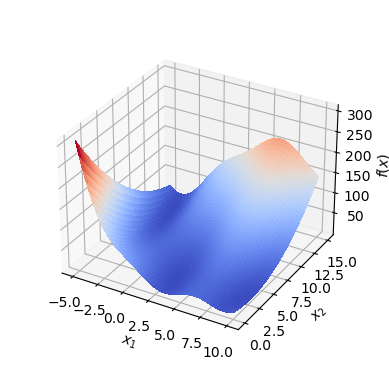

In [6]:
#3D Plot of the Branin function

from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$f(x)$')
ax.set_box_aspect(None, zoom=0.85)
# Plot the surface.
surf = ax.plot_surface(XX, YY, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

plt.savefig('Branin3D.pdf')  

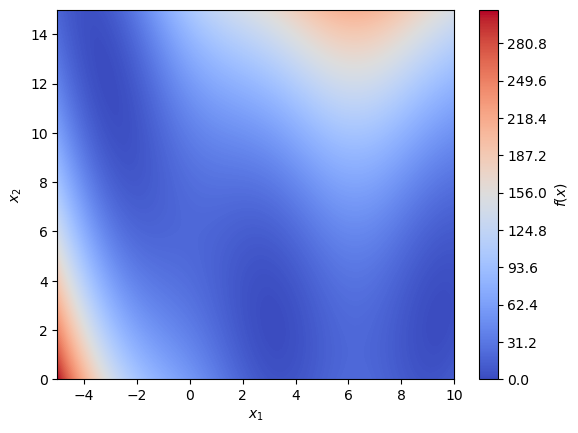

In [7]:
#Contour Plot of the Branin Function

plt.contourf(XX,YY,Z,origin='lower',levels=500,cmap=cm.coolwarm)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.colorbar(label='$f(x)$')

plt.savefig('Branin2D.pdf')  

In [8]:
# Generates 3 priors and 6 associated posteriors with 2 different observation errors

priors=[]
posterior_e1=[]
posterior_e2=[]
y_cal = 0.397887
prior_means=[[2.5,7.5],[8,2],[-5,10]] #3 prior mean locations
prior_sigmas2=[16,64,49] # 3 prior mean variances
e1=1 #Obs error 1
e2=0.1 #Obs error 2
 
for i in range(3):
    priors.append(scipy.stats.multivariate_normal.pdf(np.stack((XX,YY), axis=-1),prior_means[i],prior_sigmas2[i]*np.identity(2)))
    posterior_e1.append(priors[i]*scipy.stats.norm.pdf(Z.reshape(Z.shape[0]*Z.shape[1]),y_cal,e1).reshape(Z.shape[0],Z.shape[1]))
    posterior_e2.append(priors[i]*scipy.stats.norm.pdf(Z.reshape(Z.shape[0]*Z.shape[1]),y_cal,e2).reshape(Z.shape[0],Z.shape[1]))

In [9]:
lev=20 # levels of the contour plot

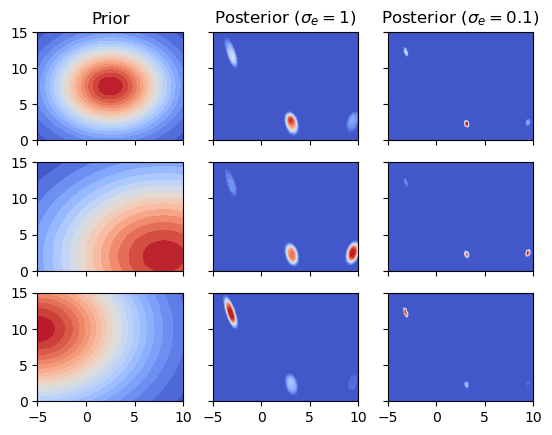

In [10]:
# Plots the three priors and 6 posteriors

fig, ((ax1, ax2,ax3), (ax4, ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3, 3)

ax1.set_title('Prior')
ax2.set_title('Posterior ($\sigma_e=$'+str(e1)+')')
ax3.set_title('Posterior ($\sigma_e=$'+str(e2)+')')

ax1.contourf(XX,YY,priors[0],origin='lower',levels=lev,cmap=cm.coolwarm)
ax2.contourf(XX,YY,posterior_e1[0],origin='lower',levels=lev,cmap=cm.coolwarm)
ax3.contourf(XX,YY,posterior_e2[0],origin='lower',levels=lev,cmap=cm.coolwarm)

ax4.contourf(XX,YY,priors[1],origin='lower',levels=lev,cmap=cm.coolwarm)
ax5.contourf(XX,YY,posterior_e1[1],origin='lower',levels=lev,cmap=cm.coolwarm)
ax6.contourf(XX,YY,posterior_e2[1],origin='lower',levels=lev,cmap=cm.coolwarm)

ax7.contourf(XX,YY,priors[2],origin='lower',levels=lev,cmap=cm.coolwarm)
ax8.contourf(XX,YY,posterior_e1[2],origin='lower',levels=lev,cmap=cm.coolwarm)
ax9.contourf(XX,YY,posterior_e2[2],origin='lower',levels=lev,cmap=cm.coolwarm)

for ax in fig.get_axes():
    ax.label_outer()
    
    

plt.savefig('BraninExactPosterior.pdf')  

In [11]:
posterior_e1[0].shape

(100, 100)

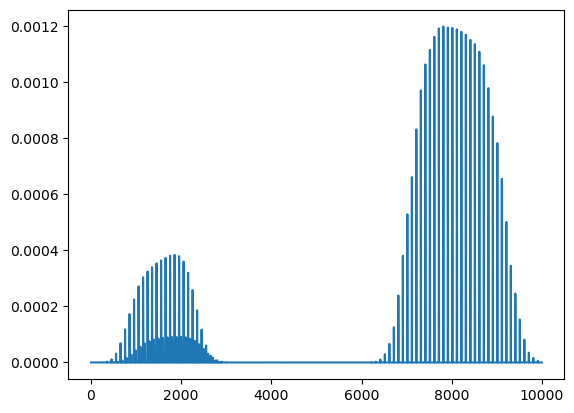

In [12]:
plt.plot(posterior_e1[2].reshape(10000))

In [13]:
# Emulator LL

def log_likelihood_emulator(y,theta,sigma2_e,emulator):
    y=torch.tensor([y])[:,None]
    theta=torch.tensor(theta)
    if theta.dim()==1:
        theta=theta[None]
    sigma2_e=torch.tensor([sigma2_e,sigma2_e])
    ll = emulator.ensemble_log_likelihood_obs_error(theta,y,sigma2_e).detach().numpy()
    return ll

In [14]:
from pyDOE import *

In [15]:
ru

[10, 15]

In [16]:
lhs(2,10,criterion='maximin')*(np.array(ru)-np.array(rl))+np.array(rl)

array([[ 9.42171762,  4.48162878],
       [ 4.53763048, 12.85083244],
       [ 8.03211313,  8.35031496],
       [-2.16532777, 13.67029516],
       [-0.45447198,  1.60493972],
       [ 6.7414511 ,  0.51930165],
       [ 2.88495476,  4.82564803],
       [ 1.06218053, 10.94197334],
       [-3.56215712,  9.41049888],
       [-1.07914352,  6.29016026]])

In [17]:
#Trains the two emulators, calculates posteriors, evaluates emulators over domain

np.random.seed(10)

posteriorE_e1=[]
posteriorE_e2=[]

i=0 # Choose which prior from the above 3
p=100 #Number of training points

#X=np.random.uniform(rl[0],ru[0],p) #Training point locations
#Y=np.random.uniform(rl[1],ru[1],p) #Training point locations

#x_train1=torch.tensor(np.array([X,Y])) #Training point locations

x_train1=torch.tensor(lhs(2,100,criterion='maximin')*(np.array(ru)-np.array(rl))+np.array(rl)).T

y_train1 = branin(x_train1) #Observations (function evaluated at training points)

emulator100=GPE.ensemble(x_train1.T,y_train1[:,None],mean_func='constant') #Train emulator using GPE ensemble

posteriorE_e1.append(priors[i]*np.exp(log_likelihood_emulator(y_cal,np.stack((XX,YY), axis=-1).reshape(10000,2),e1**2,emulator100).reshape(100,100)))

Z100=emulator100.predict(torch.tensor([XX,YY]).T).squeeze().detach().numpy() #Evaulate Emulator
p=10 #Number of training points

#X=np.random.uniform(rl[0],ru[0],p)
#Y=np.random.uniform(rl[1],ru[1],p) #Training point locations

#x_train2=torch.tensor(np.array([X,Y]))

x_train2=torch.tensor(lhs(2,10,criterion='maximin')*(np.array(ru)-np.array(rl))+np.array(rl)).T

y_train2 = branin(x_train2) #Observations (function evaluated at training points)
 

emulator10=GPE.ensemble(x_train2.T,y_train2[:,None],mean_func='constant') #Train emulator using GPE ensemble

posteriorE_e2.append(priors[i]*np.exp(log_likelihood_emulator(y_cal,np.stack((XX,YY), axis=-1).reshape(10000,2),e1**2,emulator10).reshape(100,100)))

Z10=emulator10.predict(torch.tensor([XX,YY]).T).squeeze().detach().numpy() #Evaulate Emulator

0


/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_75664/2932569047.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  Z100=emulator100.predict(torch.tensor([XX,YY]).T).squeeze().detach().numpy() #Evaulate Emulator
/var/folders/_j/ptyc01811q5b1dg30hshtfzh0000gr/T/ipykernel_75664/2932569047.py:24: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  Z100=emulator100.predict(torch.ten

0


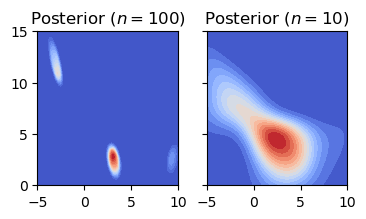

In [18]:
# Plots emulator priors and two posteriors
fig, ((ax2,ax3)) = plt.subplots(1, 2)


ax2.set_title('Posterior ($n=100$)')
ax3.set_title('Posterior ($n=10$)')


ax2.contourf(XX,YY,posteriorE_e1[0],origin='lower',levels=lev,cmap=cm.coolwarm)
ax3.contourf(XX,YY,posteriorE_e2[0],origin='lower',levels=lev,cmap=cm.coolwarm)




for ax in fig.get_axes():
    ax.label_outer()
    
fig.set_size_inches(4, 2)    

plt.savefig('BraninEmulatorPosterior.pdf')  

In [19]:
posteriorE_e2[0].argmax(axis=1)

array([56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 56, 55, 55, 55,
       54, 54, 54, 53, 53, 52, 52, 51, 51, 51, 50, 50, 49, 49, 49, 48, 48,
       47, 46, 46, 45, 44, 43, 41, 39, 37, 35, 34, 32, 30, 28, 27, 26, 24,
       23, 22, 22, 21, 20, 19, 19, 18, 18, 17, 16, 16, 15, 15, 14, 13, 13,
       12, 12, 11, 10, 10,  9,  8,  8,  7,  6,  6,  5,  4,  4,  3,  3,  2,
        2,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [20]:
i,j = np.unravel_index(posteriorE_e2[0].argmax(), posteriorE_e2[0].shape)

In [21]:
XX[i,j]

2.4242424242424248

In [22]:
YY[i,j]

4.3939393939393945

In [23]:
posteriorE_e2[0][i,j]

0.00012784341617012453

In [24]:
torch.tensor(np.stack((XX,YY))).shape

torch.Size([2, 100, 100])

In [37]:
self=emulator100
candidateInput=torch.tensor(np.stack((XX,YY), axis=-1).reshape(10000,2))
outputVal = torch.tensor([y_cal])

nMod = self.training_output_normalised.shape[1]
nDim = self.training_output_normalised.shape[0]
nP = candidateInput.shape[0]
models=self.models
likelihoods=self.likelihoods
models=self.models
likelihood_eval = torch.zeros((nMod,nP))
inputNorm,outputNorm = self.normalise_test_data(candidateInput,outputVal)
inputNorm=inputNorm.float()
outputNorm=outputNorm.float()


for i in range(nMod):
    models[i].eval()
    likelihoods[i].eval()
    sigma = e1**2
    m = likelihoods[i](models[i](inputNorm)).mean
    k = likelihoods[i](models[i](inputNorm)).covariance_matrix.diag().reshape(100,100).detach().numpy()

In [38]:
self=emulator10
candidateInput=torch.tensor(np.stack((XX,YY), axis=-1).reshape(10000,2))
outputVal = torch.tensor([y_cal])

nMod = self.training_output_normalised.shape[1]
nDim = self.training_output_normalised.shape[0]
nP = candidateInput.shape[0]
models=self.models
likelihoods=self.likelihoods
models=self.models
likelihood_eval = torch.zeros((nMod,nP))
inputNorm,outputNorm = self.normalise_test_data(candidateInput,outputVal)
inputNorm=inputNorm.float()
outputNorm=outputNorm.float()


for i in range(nMod):
    models[i].eval()
    likelihoods[i].eval()
    sigma = e1**2
    m = likelihoods[i](models[i](inputNorm)).mean
    k2 = likelihoods[i](models[i](inputNorm)).covariance_matrix.diag().reshape(100,100).detach().numpy()

In [39]:
k.min()

8.1321625e-05

In [40]:
k2.min()

0.15226981

In [27]:
k2=k2*emulator10.training_output_STD.detach().numpy()**2

In [28]:
k=k*emulator100.training_output_STD.detach().numpy()**2

In [29]:
k2.min()

189.41359612217974

In [30]:
emulator10.training_output_STD.detach().numpy()**2

array([1243.93401146])

In [31]:
emulator100.training_output_STD.detach().numpy()**2

array([2874.87621026])

In [32]:
lev=50

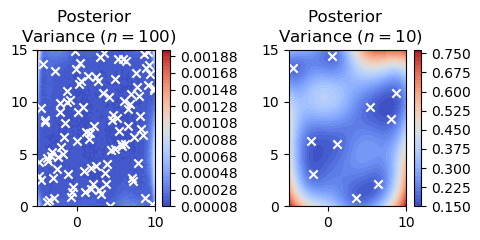

In [41]:
# Plots emulator priors and two posteriors
fig, ((ax2,ax3)) = plt.subplots(1, 2)


ax2.set_title('Posterior \n Variance ($n=100$)')
ax3.set_title('Posterior \n Variance ($n=10$)')


im1=ax2.contourf(XX,YY,k,origin='lower',levels=lev,cmap=cm.coolwarm)
im2=ax3.contourf(XX,YY,k2,origin='lower',levels=lev,cmap=cm.coolwarm)

ax2.scatter(x_train1[0],x_train1[1],c='w',marker='x')
ax3.scatter(x_train2[0],x_train2[1],c='w',marker='x')

fig.subplots_adjust(left=0.02, bottom=0.06, right=0.96, top=0.94, wspace=0.4)
fig.colorbar(im1,ax=ax2, orientation='vertical')
fig.colorbar(im2,ax=ax3, orientation='vertical')

for ax in fig.get_axes():
    ax.label_outer()
    
fig.set_size_inches(5, 2.5)    
plt.tight_layout()
plt.savefig('BraninEmulatorPosteriorVariance.pdf')  

In [301]:
x_train1[1].shape

torch.Size([100])

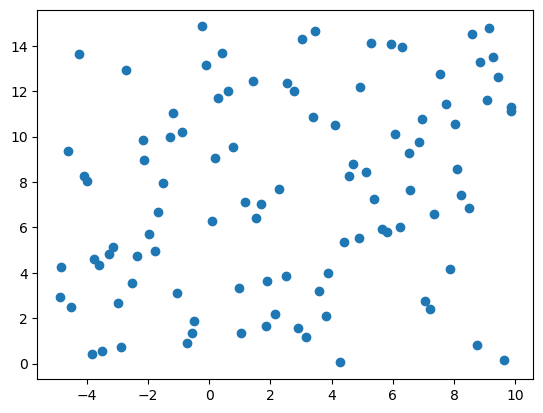

In [302]:
plt.scatter(x_train1[0],x_train1[1])

In [303]:
likelihoods[i](models[i](inputNorm)).covariance_matrix.shape

torch.Size([10000, 10000])

In [304]:
levs=np.linspace(-10,350,21) #Set levels for contour plots

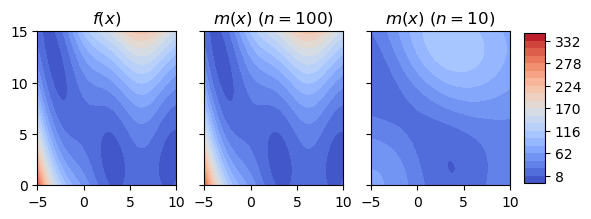

In [323]:
# Contour plots of the emulators
fig, ((ax1, ax2,ax3)) = plt.subplots(1, 3)

ax1.set_title('$f(x)$')
ax2.set_title('$m(x)$ ($n=100$)')
ax3.set_title('$m(x)$ ($n=10$)')

ax1.contourf(XX,YY,Z,origin='lower',levels=levs,cmap=cm.coolwarm)
ax2.contourf(XX,YY,Z100,origin='lower',levels=levs,cmap=cm.coolwarm)
im=ax3.contourf(XX,YY,Z10,origin='lower',levels=levs,cmap=cm.coolwarm)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.82, 0.12, 0.03, 0.75])
fig.colorbar(im,cax=cbar_ax, orientation='vertical')


for ax in fig.get_axes():
    ax.label_outer()
    
fig.set_size_inches(7, 2)      

plt.savefig('BraninEmulatorComp.pdf')  

# Calibrating with Metropolis hastings

## The metropolis hastings acceptance probability and algorithm

In [48]:
def acceptance(y,x,x_prime,m1,m2,sigma2,sigmae2): # Log acceptance probabilty (for stability)
    ratio = (-(0.5/sigma2)*((x_prime[0]-m1)**2+(x_prime[1]-m2)**2)-0.5*(1/sigmae2)*(branin(x_prime)-y)**2)-(-(0.5/sigma2)*((x[0]-m1)**2+(x[1]-m2)**2)-0.5*(1/sigmae2)*(branin(x)-y)**2)
    alpha = np.min((0,ratio))
    return alpha

In [49]:
def metrop(y_cal,x0,m1,m2,sigma2_mc,sigma2_prior,sigma2_e,iters):
    chain = np.zeros((iters+1,2)) #Initialise markov chain
    chain[0]=x0 #set x0 as first element
    for i in range(iters):
        x = chain[i] #define x
        x_p = np.random.multivariate_normal(chain[i],sigma2_mc) #select candidate value x'
        alpha = acceptance(y,x,x_p,m1,m2,sigma2_prior,sigma2_e) #calculate alpha
        u=np.random.uniform() #generate random uniform variable
        if np.log(u)<alpha: 
            chain[i+1]=x_p #accept candidate value
        else:
            chain[i+1]=x #reject candidate value
    return chain



In [50]:
y=0.397887 # Calibration value for y
sigma2_mc =0.1*np.identity(2) # MCMC proposal variance
sigma2_e=1 # Observation error variance
sigma2_prior=16
iters=10000 # Number of MCMC iterations
m1=2.5
m2=7.5

In [51]:
X=[]
x0=[[11,4],[-1,9],[5,5]]
for i in range(3):
    X.append(metrop(y,x0[i],m1,m2,sigma2_mc,sigma2_prior,sigma2_e,iters))

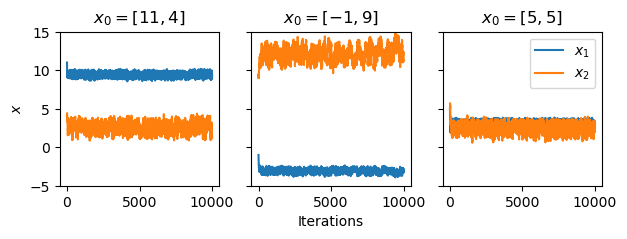

In [52]:
fig, ((ax1, ax2,ax3)) = plt.subplots(1, 3)

ax1.set_title('$x_0=[11,4]$')
ax2.set_title('$x_0=[-1,9]$')
ax3.set_title('$x_0=[5,5]$')

ax1.plot(X[0])
ax1.set_ylim([-5, 15])
ax1.set_ylabel('$x$')
ax2.plot(X[1])
ax2.set_ylim([-5, 15])
ax2.set_xlabel('Iterations')
ax3.plot(X[2])
ax3.set_ylim([-5, 15])
ax3.legend(['$x_1$','$x_2$'])


for ax in fig.get_axes():
    ax.label_outer()
    
fig.set_size_inches(7, 2)      

plt.savefig('BraninMH.pdf')  

In [62]:
sigma2_mc =5*np.identity(2) # MCMC proposal variance
sigma2_e=10 # Observation error variance
sigma2_prior=16
iters=10000 # Number of MCMC iterations
m1=2.5
m2=7.5

In [63]:
X=[]
x0=[[11,4],[-1,9],[5,5]]
for i in range(3):
    X.append(metrop(y,x0[i],m1,m2,sigma2_mc,sigma2_prior,sigma2_e,iters))

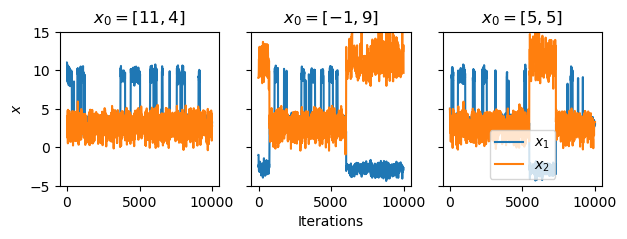

In [64]:
fig, ((ax1, ax2,ax3)) = plt.subplots(1, 3)

ax1.set_title('$x_0=[11,4]$')
ax2.set_title('$x_0=[-1,9]$')
ax3.set_title('$x_0=[5,5]$')

ax1.plot(X[0])
ax1.set_ylim([-5, 15])
ax1.set_ylabel('$x$')
ax2.plot(X[1])
ax2.set_ylim([-5, 15])
ax2.set_xlabel('Iterations')
ax3.plot(X[2])
ax3.set_ylim([-5, 15])
ax3.legend(['$x_1$','$x_2$'],loc="lower center")


for ax in fig.get_axes():
    ax.label_outer()
    
fig.set_size_inches(7, 2)      

plt.savefig('BraninMHMix.pdf')  

# BELOW THIS NOT CURRENTLY USED IN PAPER

But there's more emulator stuff and MCMC using Emcee.

In [ ]:
branin(X.mean(axis=0))

In [ ]:
plt.hist(X[10000::],density=True,bins=50)

In [ ]:
plt.hist(branin(X[10000::].T))

# Calibrating with the emcee package

In [ ]:
import emcee
ndim = 2 #Dimension of x
nwalkers = 20 # Number of emcee walkers (package recommends at least 2 x ndim)
p0 = np.random.multivariate_normal([0,0],50*np.identity(2),nwalkers) #Initial positions for walkers

## Define log-prior, log-likelihood and log-prob for emcee

In [ ]:
def log_prior(theta): #N(0,1) log pdf as the prior
    lp = -(0.5/10)*(theta[0]**2+theta[1]**2)
    return lp

def log_likelihood(y,theta,sigma2_e): #Log likelihood up to proportionality
    ll = -(0.5/(sigma2_e))*(branin(theta)-y)**2
    return ll
    
def log_prob(theta,y,sigma2_e): # Log probability (prior x likelihood)
    
    lp = log_prior(theta)
    ll =log_likelihood( y,theta,sigma2_e)
    return lp + ll

## Set up and run emcee sampler

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[y,sigma2_e]) #Set up an emcee sampler

In [ ]:
sampler.run_mcmc(p0, 10000) # Run sampler

In [ ]:
# Flatten walkers, discard first 2000 points as burn in, thin the samples by 10

flat_samples = sampler.get_chain(discard=2000, thin=10, flat=True) 
print(flat_samples.shape)

## Plot a histogram of the MCMC posterior, the true posterior and the prior

In [ ]:
plt.hist(flat_samples,density=True,bins=100)


## Plot the trace plot

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");


In [ ]:
branin(sampler.get_chain(thin=10,flat=True).mean(axis=0))

In [ ]:
flat_samples

In [ ]:
X[10000::]

In [ ]:
plt.hist(branin(flat_samples.T),density=True)

# MCMC with an emulator in place of $f(x)$

In [ ]:
p=50 #Number of training points

X=np.random.uniform(rl[0],ru[0],p)
Y=np.random.uniform(rl[1],ru[1],p) #Training point locations

x_train=torch.tensor(np.array([X,Y]))

y_train = branin(x_train) #Observations (function evaluated at training points)

In [ ]:
y_train.shape

In [ ]:
emulator=GPE.ensemble(x_train.T,y_train[:,None],mean_func='constant') #Train emulator using GPE ensemble

In [ ]:
Z2=emulator.predict(torch.tensor([XX,YY]).T).squeeze().detach().numpy()

## Plot emulator against true $f(x)$

In [ ]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(XX, YY, Z2, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

In [ ]:
from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(XX, YY, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

## Rewrite log-likelihood and log-prob to account for emulator

In [ ]:
torch.tensor([0,0])[None]

In [ ]:
def log_likelihood_emulator(y,theta,sigma2_e,emulator):
    y=torch.tensor([y])[:,None]
    theta=torch.tensor(theta)
    if theta.dim()==1:
        theta=theta[None]
    sigma2_e=torch.tensor([sigma2_e,sigma2_e])
    ll = emulator.ensemble_log_likelihood_obs_error(theta,y,sigma2_e).detach().numpy()
    return ll
    
def log_prob_emulator(theta,y,sigma2_e,emulator):
    
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll =log_likelihood_emulator(y,theta,sigma2_e,emulator)
    return lp + ll

In [ ]:
log_likelihood_emulator(y,[0,0],sigma2_e,emulator)

## Plot the log-likelihood over the domain

In [ ]:
test=torch.tensor([XX,YY]).T
test.reshape(2500,2).shape

In [ ]:
Z3=log_likelihood_emulator(y,test.reshape(2500,2),sigma2_e,emulator).T

In [ ]:


from matplotlib import cm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Plot the surface.
surf = ax.plot_surface(XX, YY, Z3.reshape((50,50)), cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

## Set up and run emcee sampler

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_emulator, args=[y,sigma2_e,emulator])

In [ ]:
p0

In [ ]:
sampler.run_mcmc(p0, 10000)

In [ ]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].set_xlabel("step number");

## Plot True posterior against Emulator MCMC, True MCMC and prior

In [ ]:
flat_samples = sampler.get_chain(discard=2000, thin=10, flat=True)
plt.hist(flat_samples,density=True)


In [ ]:
empred=emulator.predict(torch.tensor(flat_samples)).detach().numpy()

In [ ]:
plt.plot(empred)

In [ ]:
plt.hist(empred,density=True)